# Selection of components for the field of light


In [1]:
%matplotlib notebook
import math
from scipy import integrate
import pandas as pd
import functools
import LEDs
import scipy.ndimage.filters as sp_filters
from LEDs import CSVDatabase, LED, Optics, LightField
import pickle
import itertools

#
# Constants
#
sun_ppfd = 2200  # PPFD of the Sun, the one we want to mimick
shelf_surface = 0.51 * 0.72  # The surface to cover at sun PPFD
cost_kwh = 0.26  # Cost of electricity per kWh, considering both supply and delivery charges...
moles_per_m2_per_day = 50  # Number of moles of photon per meter square per day 

Let's first load the component databases

In [2]:
optics_db = CSVDatabase('Light/Optics.csv')
led_db = CSVDatabase('Light/LEDs.csv')
led_db.db.set_index(['brand', 'model', 'serial_number'])

FileNotFoundError: File b'Light/Optics.csv' does not exist

Now, let's generate at the optics-LED pairs we have in file

In [3]:
pairs = list()
for l in led_db:
    for o in optics_db.find(led_brand=l['brand'], led_model=l['model']).iterrows():
        try:
            led = LED(l, z=0.1)
            optics = Optics(o[1])
            optics.estimate()
            led.optics = optics
            pairs.append(led)
        except FileNotFoundError:
            pass
pairs

Let's look at one of our pairs

In [4]:
pair = pairs[-1]

pair.description, pair.optics.description

($                                         9.63
 current                                    1.4
 cri                                         80
 temperature                               3000
 voltage                                   33.4
 brand                                Bridgelux
 lumens                                    6846
 serial_number                BXRE-30E6500-D-73
 note                                       NaN
 ppf                                        NaN
 model                                      V22
 spectrum         Bridgelux V22 3000K 80CRI.csv
 Name: 27, dtype: object, index                            9
 brand                    Bridgelux
 series                         V22
 model                          NaN
 serial_number                  NaN
 led_brand                Bridgelux
 led_model                      V22
 efficiency                       1
 file             Bridgelux V22.csv
 Name: 2, dtype: object)

In [5]:
pair.ppf

102.03227889278139

<IPython.core.display.Javascript object>


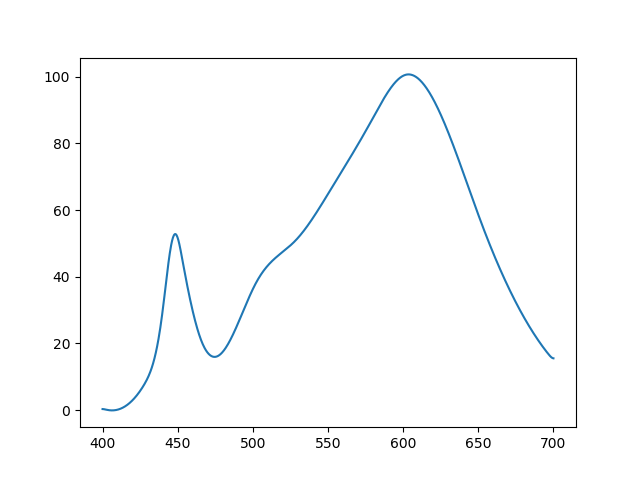

In [11]:
plt.figure()
x = np.linspace(400, 700, 1000)
plt.plot(x, sp_filters.gaussian_filter1d(pair.spectrum(x), 5))

## Using a spline

<IPython.core.display.Javascript object>


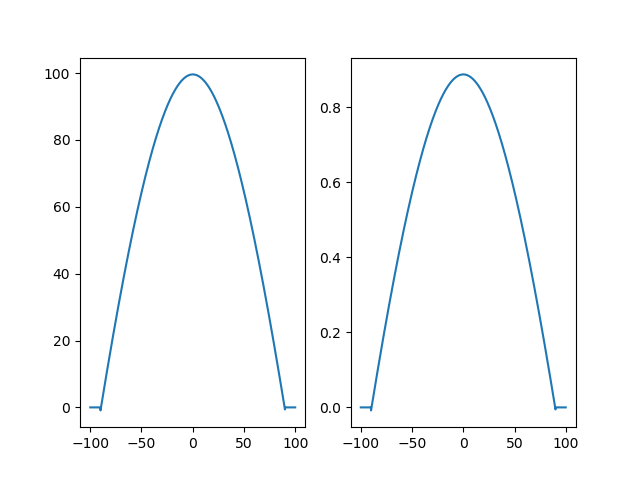

In [12]:
plt.figure()
x = np.linspace(-100, 100, 1000)
plt.subplot(121)
plt.plot(x, pair.ard(x))
plt.subplot(122)
plt.plot(x, pair.axial_photon_flux_distribution(x))

In [17]:
pair.distal_photon_flux_density_distribution(0.001, 0.001, 1)

(1.001, 1.001) (-0.999, -0.999) 0.008062542143534301 1.4156277759354678 1.412799348810722 0.02513274122871488 0.00716084863485908


0.2849211142427076

# next

<IPython.core.display.Javascript object>


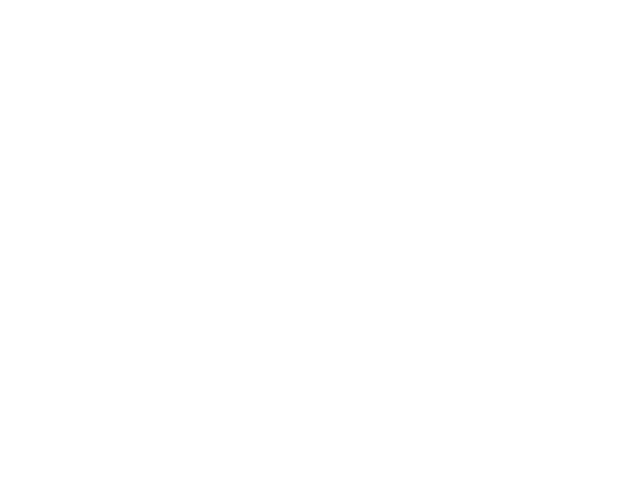

AttributeError: 'Optics' object has no attribute 'drd'

In [10]:
plt.figure()
center = (0, 0)
x, y = np.meshgrid(np.linspace(-1000, 1000, 1000), np.linspace(-1000, 1000, 1000))

field = pair.optics.drd(x, y, 0.1, center)

contours = plt.contourf(x, y, field)
plt.axis('equal')
plt.plot(center[0], center[1], 'rx')
plt.colorbar()


In [ ]:
plt.figure()
center = (0, 0)
x, y = np.meshgrid(np.linspace(-0.36, 0.36, 1000), np.linspace(-0.255, 0.255, 1000))
field = pair.distal_flux_density_distribution(x, y, 0.1, center)
# plt.imshow(field)
contours = plt.contourf(x, y, field)
plt.plot(center[0], center[1], 'rx')
# plt.clabel(contours, inline=True, fontsize=8)
plt.colorbar()

In [ ]:
with open('Light/pairs.pckl', 'wb') as f:
    pickle.dump(pairs, f)

## Generate areas under the curve at different z values
Calculating the AUC is slow. I can generate a bunch of them for all the pairs, so that I can move forward faster, later on.

In [ ]:
with open('Light/pairs.pckl', 'rb') as f:
    pairs = pickle.load(f)

I'll calculate at different levels of precisions so that I can move forward with coarser zs without having to way too long. I don't loose time doing it because it won't recalculate the AUCs at a given z if it was already calculated.

In [ ]:
coarse_zs = np.arange(0.1, 0.9, 0.1)
medium_zs = np.arange(0.1, 0.9, 0.05)
smooth_zs = np.arange(0.1, 0.9, 0.01)
z_sets = [coarse_zs, medium_zs, smooth_zs]

In [ ]:
for zs in z_sets:
    for z in zs:
        for pair in pairs:
            # Calculate
            pair.optics.area_under_drd(z)

            # Save the list every single time, because I'll probably kill the calculations several times
            with open('Light/pairs.pckl', 'wb') as f:
                pickle.dump(pairs, f)

In [ ]:
for pair in pairs:
    display(pair.optics.integral_drd)

## Generate fields of light

In [ ]:
with open('Light/pairs.pckl', 'rb') as f:
    leds = pickle.load(f)

In [ ]:
for i, led in enumerate(leds):
    display(i, led.description, led.optics.description)

In [ ]:
def uniform_spacing_rectangle(w, d, n):
    """
    Generate a light field by positioning LEDS equidistantly in a rectangular fashion
    
    Should look into this to be able to use the exact number of LEDs: https://www.google.com/search?q=packing+circles+in+a+square&oq=packing+circles+in+a+square&gs_l=psy-ab.3..0j0i22i30k1l3.260412.264878.0.265455.27.24.0.0.0.0.291.3337.0j15j5.20.0....0...1.1.64.psy-ab..7.20.3331...35i39k1j0i67k1j0i20k1.0.EUPmkYp_Qy4
  
    w: width of the illumination area (m)
    d: depth of the illumination area (m)
    h: height of the LEDs from the illumination area (m)
    n: number of LEDs in the system
    """
    n_w = int(round(np.sqrt(w*n/d),0))
    n_d = int(round(n / n_w))
    x, y = np.meshgrid(range(n_w), range(n_d))
    unit_w = w / n_w
    unit_d = d / n_d
    positions = np.stack([(x.ravel() + 0.5) * unit_w, (y.ravel() + 0.5) * unit_d], 1)
    return positions, n_w * n_d

In [ ]:
led = leds[16]
d = 0.51
w = 0.72
z = 0.2
positions = uniform_spacing_rectangle(w, d, 12)[0]
positions = [(x, y, z, (0, 0), led) for x, y in positions]
L = LightField(positions)

In [ ]:
plt.figure()
plt.contourf(L.estimate(w, d))
plt.colorbar()

In [ ]:
led.optics.integral_drd

In [ ]:
plt.figure()
x = np.linspace(-0.35, 0.35, 100)
y = np.linspace(-0.25, 0.25, 100)
x, y = np.meshgrid(x, y)
z = led.optics.drd(x, y, z)
# plt.axes().set_aspect('equal')
plt.pcolor(x, y, z)
plt.colorbar()

**I have an issue with my AUC calculation. Probably, the boundaries are not working. I need to look into this.**